### ✅ Problem Statement

Mental health conversations often require high empathy, personalized responses, and contextual understanding—something general-purpose Large Language Models (LLMs) may lack when trained only on broad, internet-scale datasets. To deploy safe, relevant, and emotionally intelligent conversational agents in mental wellness applications, it's essential to fine-tune these models on domain-specific counseling dialogues.

This project aims to **fine-tune a powerful open-source LLM (DeepSeek-R1-Distill-Llama-8B)** using the **ShareGPT-style mental health counseling dataset**, leveraging **Unsloth** for fast, memory-efficient fine-tuning with LoRA adapters.

---

### 🎯 Objectives

1. **Load and prepare** a high-quality dataset (`Sulav/mental_health_counseling_conversations_sharegpt`) in ShareGPT-style format and convert it to Hugging Face-compatible chat format.

2. **Initialize the DeepSeek-R1-Distill-Llama-8B model** using Unsloth with:
   - 4-bit quantization for memory efficiency.
   - Native chat template support (`llama-3.2`).
   - LoRA adapter injection for parameter-efficient fine-tuning.

3. **Apply role-based formatting** using `get_chat_template()` to align with conversational style fine-tuning.

4. **Use SFTTrainer from HuggingFace TRL** with Unsloth-optimized settings for:
   - Training only on **assistant responses**.
   - Low VRAM usage with efficient gradient accumulation and 8-bit optimizer.

5. **Evaluate** the model using natural prompts and assess contextual alignment with mental health inputs.

6. **Save** the fine-tuned model and tokenizer for reuse in inference pipelines or chatbot integrations.

---

### ✅ Expected Outcomes

- A **fine-tuned conversational LLM** that generates safe, empathetic, and relevant responses in mental health contexts.
- **LoRA-adapted, resource-efficient training**, enabling fine-tuning on standard GPUs.
- A **cleanly formatted, reusable model** trained with minimal data and cost, deployable in apps like:
  - AI therapy assistants
  - Mental health support chatbots
  - HR wellness bots
- A working **inference pipeline** that demonstrates high-quality generation on emotionally sensitive prompts (e.g., “I failed my interview and feel hopeless.”).

---

In [ ]:
# Install required libraries
%%capture

# Unsloth is the core library used to load and fine-tune LLMs like LLaMA and DeepSeek efficiently, especially on low-memory GPUs.
# Enables features like LoRA (parameter-efficient tuning), chat templates, 4-bit loading, and HuggingFace Trainer support.
!pip install unsloth==2025.2.4

# Unsloth Zoo provides predefined model configurations and chat templates (like llama-3.2).
# This ensures consistent prompt formatting and tokenizer behavior across supported models.
!pip install unsloth_zoo==2025.2.3

!pip install torch==2.5.1 # Needed for model computation (CPU/GPU).
!pip install torchaudio==2.5.1
!pip install torchvision==0.20.1

# vLLM is a high-performance LLM inference engine.
# It's not required for training, but very useful if you want to serve the fine-tuned model efficiently later.
!pip install vllm==0.7.2

# xFormers accelerates Transformer operations (like attention layers).
# This improves training and inference speed for Hugging Face and Unsloth models.
!pip install xformers==0.0.28.post3

# xGrammar is an emerging tool to enforce structured output generation in LLMs (like JSON, SQL, etc.).
# Not directly used here, but useful in safe generation tasks where format matters.
!pip install xgrammar==0.1.11

!pip install --force-reinstall --no-cache-dir --no-deps git+https://github.com/unslothai/unsloth.git

# TRL (Transformers Reinforcement Learning) is used for Supervised Fine-Tuning (SFTTrainer) in this project.
# Makes it easier to train LLMs with HuggingFace-style trainers on text-generation tasks.
!pip install trl==0.8.2

In [ ]:
#Load the original Model and Tokenizer

from unsloth import FastLanguageModel # FastLanguageModel is Unsloth’s wrapper class around LLaMA-based models.
# It supports features like LoRA, 4-bit quantization, and chat templates.

import torch # torch is needed for all deep learning computations.

# Define configurations for loading the model
# This sets the maximum number of tokens your model can process at once.
# 2048 is common for 8B models and is enough for most conversations.
max_seq_length = 2048

# allows Unsloth to auto-select the best precision format based on your hardware.
dtype = None  # Automatically choose the best data type (float16, bfloat16, etc.)

# Loading in 4-bit drastically reduces the memory footprint (from 30-40GB down to ~6-8GB).
# QLoRA-style quantization is used under the hood.
load_in_4bit = True  # Enable 4-bit quantization to reduce memory usage

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name="unsloth/DeepSeek-R1-Distill-Llama-8B",
    max_seq_length=max_seq_length,
    dtype=dtype,
    load_in_4bit=load_in_4bit
)
# Why DeepSeek R1 Distilled?
# DeepSeek R1 Distilled is a smaller, faster version of the original DeepSeek model.
# It retains most of the original's capabilities while being more efficient.
# This makes it a great choice for fine-tuning, especially if you're working with limited resources.
# It’s also a good starting point for tasks that require less computational power.
# This model is designed to be efficient and effective for a wide range of tasks.
# The model is based on the LLaMA architecture, which is known for its performance and flexibility.
# The 8B version is a good balance between performance and resource usage.

Unsloth: Patching Xformers to fix some performance issues.
🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.2.15: Fast Llama patching. Transformers: 4.48.3.
   \\   /|    GPU: Tesla T4. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.96G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/236 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/53.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
from unsloth.chat_templates import get_chat_template

tokenizer = get_chat_template(
   tokenizer,
   chat_template = "llama-3.2",
)
# This formats conversations (user + assistant roles) using the style expected by LLaMA 3.2, e.g.:
# <|start_header_id|>user<|end_header_id|>
# Hello

# <|start_header_id|>assistant<|end_header_id|>
# Hi there!


# Set the PAD token to be the same as the EOS token to avoid tokenization issues
tokenizer.pad_token = tokenizer.eos_token # Sets the padding token (pad_token) to the same as the end-of-sequence (eos_token).

# Optimizes the model for inference (not training).
# Enables 2x faster response generation with Unsloth’s internal tweaks.
FastLanguageModel.for_inference(model) # Enable native 2x faster inference

messages = [
   {"role": "user", "content": "I am mentally very upset because I failed my job interview today"}]
# Tokenize the user input with the chat template
inputs = tokenizer.apply_chat_template(
   messages,
   tokenize=True,
   add_generation_prompt=True,
   return_tensors="pt",
   padding=True,  # Add padding to match sequence lengths
).to("cuda")

# Creates a binary mask: 1 where there's actual data, 0 where there's padding.
# Helps the model focus only on real tokens during generation.
attention_mask = inputs != tokenizer.pad_token_id

outputs = model.generate(
   input_ids=inputs,
   attention_mask=attention_mask,
   max_new_tokens=64,
   use_cache=True,  # Use cache for faster token generation
   temperature=0.6,  # Controls randomness in responses
   min_p=0.1,  # Set minimum probability threshold for token selection
)

# Decode the generated tokens into human-readable text
text = tokenizer.decode(outputs[0], skip_special_tokens=True) # Converts token IDs back into a readable string. Removes system tokens like <s>, <pad>, etc.
print(text)

system

Cutting Knowledge Date: December 2023
Today Date: 26 July 2024

user

I am mentally very upset because I failed my job interview todayassistant

</think>

I'm really sorry to hear that you had a tough experience with your job interview. It's completely normal to feel upset after something like that. Here are a few things that might help:

1. **Take Some Time Off**: It's okay to take a break. Your mind and emotions deserve some space right


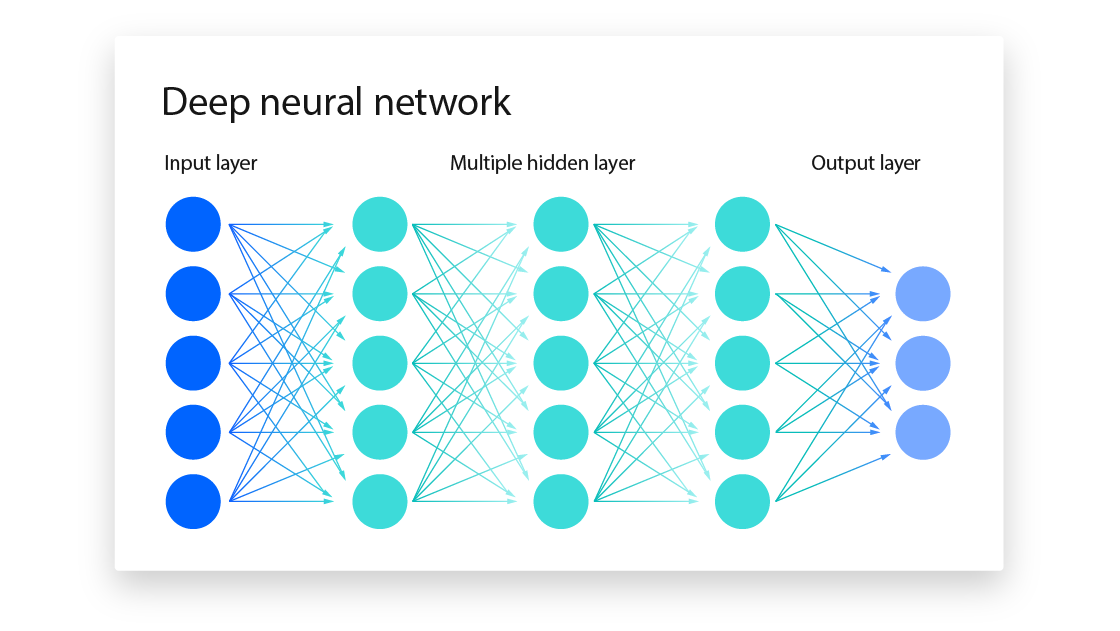

In [ ]:
# Apply LoRA Adapters for Efficient Fine-Tuning

model = FastLanguageModel.get_peft_model(
    model,
    r=16,  # LoRA rank (controls low-rank approximation quality). sets the LoRA rank, which controls the "expressiveness" of the low-rank matrices.
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],  # Layers to apply LoRA. Higher r = more learnable capacity, but also slightly more compute.
    lora_alpha=16, # Scaling factor for LoRA weights
    lora_dropout=0,
    bias="none",
    use_gradient_checkpointing="unsloth",
    random_state=3407,
    use_rslora=False,
    loftq_config=None
)

Unsloth 2025.2.15 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


In [5]:
# Prepare the Training Dataset

from datasets import load_dataset  # Load datasets from Hugging Face Hub

# Load a dataset
dataset = load_dataset("Sulav/mental_health_counseling_conversations_sharegpt", split="train")

README.md:   0%|          | 0.00/624 [00:00<?, ?B/s]

(…)-00000-of-00001-3193672bedc3e534.parquet:   0%|          | 0.00/4.92M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3512 [00:00<?, ? examples/s]

In [6]:
import unsloth

In [7]:
# convert the dataset from ShareGPT style (“from”, ”value”) to Hugging face generic format(“role”, “content”)

from unsloth.chat_templates import standardize_sharegpt

# Convert dataset format from ShareGPT format to Hugging Face's standardized ("role", "content") structure
dataset = standardize_sharegpt(dataset)

Standardizing format:   0%|          | 0/3512 [00:00<?, ? examples/s]

In [8]:
"""For example, a dataset entry in ShareGPT format:

{"from": "system", "value": "You are an assistant"}
{"from": "human", "value": "What's the capital of France?"}
{"from": "gpt", "value": "The capital of France is Paris."}

is converted to role-based Hugging Face's format:

{"role": "system", "content": "You are an assistant"}
{"role": "user", "content": "What's the capital of France?"}
{"role": "assistant", "content": "The capital of France is Paris."}
"""

'For example, a dataset entry in ShareGPT format:\n\n{"from": "system", "value": "You are an assistant"}\n{"from": "human", "value": "What\'s the capital of France?"}\n{"from": "gpt", "value": "The capital of France is Paris."}\n\nis converted to role-based Hugging Face\'s format:\n\n{"role": "system", "content": "You are an assistant"}\n{"role": "user", "content": "What\'s the capital of France?"}\n{"role": "assistant", "content": "The capital of France is Paris."}\n'

In [9]:
# Format Prompts
# Once the dataset is prepared, we need to ensure that the data is structured correctly to be used by the model. For this, we apply
# the appropriate chat template (we have used the Llama-3.2 format.) using the get_chat_template function. This function basically prepares
# the tokenizer with the Llama-3.2 chat format for conversation-style fine-tuning

from unsloth.chat_templates import get_chat_template

# Apply the Llama-3.2 chat template to the tokenizer
tokenizer = get_chat_template(
    tokenizer,  # Tokenizer being used
    chat_template="llama-3.2",  # The chat template format
)

# Function to format the conversation data into tokenized text
def formatting_prompts_func(examples):
    convos = examples["conversations"]
    texts = [tokenizer.apply_chat_template(convo, tokenize=False, add_generation_prompt=False) for convo in convos]
    return {"text": texts}

dataset = dataset.map(formatting_prompts_func, batched=True)

Model does not have a padding token! Will use pad_token = <|finetune_right_pad_id|>.


Map:   0%|          | 0/3512 [00:00<?, ? examples/s]

In [ ]:
# Print an item in its original conversation format
print(dataset[0]["conversations"])

print("-----------------")
print("Formatted Text")
print("-----------------")

# Print the same item in its formatted text format
print(dataset[0]["text"])

[{'content': "I'm going through some things with my feelings and myself. I barely sleep and I do nothing but think about how I'm worthless and how I shouldn't be here.\n   I've never tried or contemplated suicide. I've always wanted to fix my issues, but I never get around to it.\n   How can I change my feeling of being worthless to everyone?", 'role': 'user'}, {'content': "If everyone thinks you're worthless, then maybe you need to find new people to hang out with.Seriously, the social context in which a person lives is a big influence in self-esteem.Otherwise, you can go round and round trying to understand why you're not worthless, then go back to the same crowd and be knocked down again.There are many inspirational messages you can find in social media. \xa0Maybe read some of the ones which state that no person is worthless, and that everyone has a good purpose to their life.Also, since our culture is so saturated with the belief that if someone doesn't feel good about themselves t

In [ ]:
# Setup and Configure the Trainer
# configure the fine-tuning process using Hugging Face’s SFTTrainer. It automates key tasks like tokenization, batching, and optimization,
# making fine-tuning easier. SFTTrainer works efficiently with Unsloth, reducing VRAM usage and speeding up training

from trl import SFTTrainer # Specialized trainer for Supervised Fine-Tuning (SFT) from Hugging Face’s trl library.
from transformers import TrainingArguments, DataCollatorForSeq2Seq
# TrainingArguments: Controls batch size, learning rate, logging, device usage, etc.
# DataCollatorForSeq2Seq: Automatically pads inputs and labels for variable-length sequences.
from unsloth import is_bfloat16_supported


# Define training configurations
trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=dataset,
    dataset_text_field="text", # Tells trainer which field in dataset to use for model inputs.
    max_seq_length=max_seq_length, # Maximum input length the model can handle.
    data_collator=DataCollatorForSeq2Seq(tokenizer=tokenizer),
    dataset_num_proc=2,
    packing=False,

    args=TrainingArguments(
        per_device_train_batch_size=2,  # Number of examples per GPU batch
        gradient_accumulation_steps=4,  # Accumulate gradients over 4 batches before updating model
        warmup_steps=5,  # Number of warmup steps for learning rate schedule
        max_steps=0,  #
        num_train_epochs=1,
        learning_rate=2e-4,
        fp16=not is_bfloat16_supported(),
        bf16=is_bfloat16_supported(),
        logging_steps=1,  # Log training metrics after every step
        optim="adamw_8bit",
        weight_decay=0.01,
        lr_scheduler_type="linear",  # Linear decay of learning rate
        seed=3407,
        output_dir="outputs",  # Directory to save model checkpoints
        report_to="none",  # Use this for WandB etc

    ),
)

Map (num_proc=2):   0%|          | 0/3512 [00:00<?, ? examples/s]

In [12]:
# Train Only on Assistant Responses
# To improve training efficiency, we will focus only on the assistant’s responses rather than user inputs.

from unsloth.chat_templates import train_on_responses_only
trainer = train_on_responses_only(
    trainer,
    instruction_part="<|start_header_id|>user<|end_header_id|>\n\n",  # Mark user input
    response_part="<|start_header_id|>assistant<|end_header_id|>\n\n",  # Mark assistant response
)
# Start training the model
trainer_stats = trainer.train()

Map:   0%|          | 0/3512 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 3,512 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 439
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss
1,3.496600
2,3.115900
3,3.296000
4,3.457800
5,3.203400
6,3.110600
7,2.621300
8,2.967300
9,2.843100
10,2.825300


Step,Training Loss
1,3.496600
2,3.115900
3,3.296000
4,3.457800
5,3.203400
6,3.110600
7,2.621300
8,2.967300
9,2.843100
10,2.825300


In [13]:
# Inference

tokenizer = get_chat_template(
   tokenizer,
   chat_template = "llama-3.2",
)
# Set the PAD token to be the same as the EOS token to avoid tokenization issues
tokenizer.pad_token = tokenizer.eos_token
FastLanguageModel.for_inference(model) # Enable native 2x faster inference

messages = [
   {"role": "user", "content": "I am mentally very upset because I failed my job interview today"}]
# Tokenize the user input with the chat template
inputs = tokenizer.apply_chat_template(
   messages,
   tokenize=True,
   add_generation_prompt=True,
   return_tensors="pt",
   padding=True,  # Add padding to match sequence lengths
).to("cuda")

attention_mask = inputs != tokenizer.pad_token_id

outputs = model.generate(
   input_ids=inputs,
   attention_mask=attention_mask,
   max_new_tokens=64,
   use_cache=True,  # Use cache for faster token generation
   temperature=0.6,  # Controls randomness in responses
   min_p=0.1,  # Set minimum probability threshold for token selection
)

# Decode the generated tokens into human-readable text
text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(text)

system

Cutting Knowledge Date: December 2023
Today Date: 26 July 2024

user

I am mentally very upset because I failed my job interview todayassistant

It is hard to know whether or not you will get the job.  I would suggest that you give yourself some time to rest and recover from the stress of the interview.  I would also suggest that you look at the situation in a new light, such as what you learned from the interview process and how


In [14]:
my_model="DeepSeek-r1-finetuned-8B"
model.save_pretrained(my_model)  # Local saving
tokenizer.save_pretrained(my_model)

('DeepSeek-r1-finetuned-8B/tokenizer_config.json',
 'DeepSeek-r1-finetuned-8B/special_tokens_map.json',
 'DeepSeek-r1-finetuned-8B/tokenizer.json')